In [1]:
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import time
import json
import functions

function for calculating *Symmetric Mean Absolute Percentage Error*.

In [2]:
def smape(predictions, actual):
    difference = np.abs(predictions-actual)
    summation = np.abs(actual)+np.abs(predictions)
    error = np.mean(2*difference/summation)
    return error

Since now we can't use *ada_preprocessing()* to extract lagged values and concept, because it can potentially mess up breakpoint detection, we need separate function for this.

In [3]:
def manual_preprocessing(values, pattern):
    #receives the list of values up until and including the test point
    
    #extract the column names
    columns = list(pattern.columns)
    
    #append lagged values
    data = [values[-1], values[-2], values[-3], values[-4], values[-5], values[-6]]
    
    #append the same concept dummies as from the last training point
    for i in range(1, list(pattern.columns)[-1]+1):
        data.append(int(pattern.loc[:,i]))
    
    #create the dataframe
    df = pd.DataFrame(columns=columns, data=[data])
    
    return df

Because we are in forecasting mode, we cannot shuffle the data for evaluation. Instead we are going to use *walk-forward validation*.<br><br>
In walk-forward validation, the dataset is first split into train and test sets using a cut-point. If we are interested in one time-step forecast, then we can evaluate the model by training on the training set and predicting first step in the test dataset. Then add the real observation from test set to the training, refit the model, predict the second step and so on...

In [4]:
def walk_forward_validation(train, test):
    predictions = []
    history = functions.ada_preprocessing(train)
    
    # iterate over each time-step in the test set
#     for i in range(len(test)):
        #create lagged values for new test observation
    train.append(test)
    lagged_df = manual_preprocessing(train)
#         print(history.tail())

    # split test row into input and output columns
    #target y is the first column in the dataset
    test_X, test_y = lagged_df.iloc[:, 1:], lagged_df.iloc[:, 0]

    # fit model on history and make a prediction
    yhat = xgboost_forecast(history, test_X)
    predictions.append(yhat)
        
        # add actual observation to training data for the next iteration
#         history = history.append(lagged_df, ignore_index = True)
        
    # estimate prediction error
    error = smape(np.asarray(predictions), np.asarray(test))
    
    return error, test, predictions

In [5]:
def xgboost_forecast(train, test_X):
    train_X, train_y = train.iloc[:,1:], train.iloc[:,0]
    
    model = XGBRegressor(objective = 'reg:squarederror', n_estimators = 100, random_state = 40)
    model.fit(train_X, train_y)
    yhat = model.predict(test_X)
    
    return yhat[0]

In [6]:
def one_hot_encoding(data):
    n = len(data)
    
    #transforming concept and transition columns
    one_hot_encoded = pd.get_dummies(data["concept"])
    data.drop("concept", axis = 1, inplace = True)
    data = pd.concat([data, one_hot_encoded], axis = 1, sort = False)
    
    #for now i'm dropping these columns, cause there was no improvement in accuracy
    #by including them so far
    data.drop(["transition", "steps_to_bkp", "steps_since_bkp"], axis = 1, inplace = True)
    
    return data

In [7]:
#takes about an hour for one dataset, so i'm not eager to test on all of them

#so chose the worst performing datasets from xgboost with retrain
list_of_names = ["nonlinear1_abrupt", "nonlinear1_inc"]

# list_of_names = ["linear1_abrupt", "linear2_abrupt", "linear3_abrupt",
#                 "nonlinear1_abrupt", "nonlinear2_abrupt", "nonlinear3_abrupt",
#                 "linear1_inc", "linear2_inc", "linear3_inc",
#                 "nonlinear1_inc", "nonlinear2_inc", "nonlinear3_inc"]

Time wasted: 51.34m
SMAPE: 1.3739


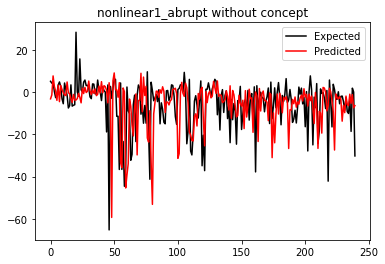

Time wasted: 50.01m
SMAPE: 1.4356


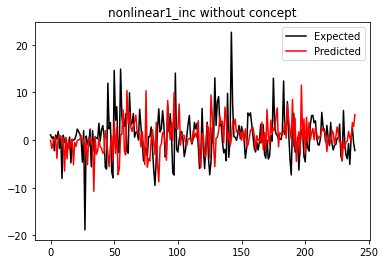

In [9]:
#dictionary to store the overall error
smape_dict = {}

#store the error for every step for both datasets
error1 = []
error2 = []

for name in list_of_names:
    start = time.perf_counter()
    
    #loading the data
    file_path = "data/"+name+"_series"
    data = pd.read_csv(file_path).iloc[:,0].to_list()
    
    #70/30 train/test split
    split = int(0.7*len(data))
    train, test = data[:split], data[split:]
    
    predictions = []
    ground_truth = []
    
    for i in range(len(test)):
        #get breakpoints for train
        history = functions.ada_preprocessing(train)
        history = one_hot_encoding(history)
        
        #add new test observation to train series
        train.append(test[i])
        
        #path the last point from history dataframe to then extract same concept dummies
        test_df = manual_preprocessing(train, history.tail(1))
        
        ground_truth.append(train[-1])
        
        #training data = history
        prediction = xgboost_forecast(history, test_df.loc[:,"t-1":])
        predictions.append(prediction)
        
        #error at every step by daniel's request :D
        if name == "nonlinear1_abrupt":
            error1.append(smape(np.asarray(predictions), np.asarray(ground_truth)))
        else:
            error2.append(smape(np.asarray(predictions), np.asarray(ground_truth)))
            
    end = time.perf_counter()
    print("Time wasted: {:.2f}m".format((end-start)/60))
    
    error = smape(np.asarray(predictions), np.asarray(ground_truth))
    smape_dict[name] = error
    print("SMAPE: {:.4f}".format(error))
    plt.plot(ground_truth, label = "Expected", color = "black")
    plt.plot(predictions, label = "Predicted", color = "red")
    plt.legend()
    plt.title("{} without concept".format(name))    
    plt.show()

In [10]:
error1

[2.0,
 2.0,
 1.4972039796760248,
 1.5269596181640872,
 1.6215676945312698,
 1.546879413427227,
 1.3259445088797561,
 1.4102014452697864,
 1.2740139860247381,
 1.3466125874222643,
 1.388359820869488,
 1.4393298357970306,
 1.4824583099664896,
 1.519425573540312,
 1.5414745967458627,
 1.5404561469989564,
 1.567488138351959,
 1.497513598038051,
 1.4919169361751097,
 1.439782528446867,
 1.4664595509017782,
 1.4907113894971518,
 1.4704292962279866,
 1.492494742218487,
 1.5127949525297475,
 1.5173603458555183,
 1.5352358886016102,
 1.5117457439963427,
 1.528582097651641,
 1.529326914579875,
 1.507134307626985,
 1.5225363605136417,
 1.5032185628141632,
 1.4937056996390927,
 1.508171251077976,
 1.5218331607702542,
 1.4975522850787535,
 1.5107745933661547,
 1.497135907055929,
 1.5097075093795307,
 1.5216658628092983,
 1.5330547708376483,
 1.5272129047868936,
 1.5372567210092911,
 1.5475399049868626,
 1.5573759940088872,
 1.5667935260512513,
 1.5758186609251839,
 1.5806300763029968,
 1.5691028222

In [11]:
error2

[2.0,
 2.0,
 2.0,
 2.0,
 1.7000611439599775,
 1.7500509532999813,
 1.6497608156518389,
 1.693540713695359,
 1.5400200337723868,
 1.5669876589264269,
 1.509151319612969,
 1.5249560576708812,
 1.4343864812898452,
 1.369922190301687,
 1.3976554405810804,
 1.4353019755447627,
 1.452860087793883,
 1.4582809779800519,
 1.4855575844518438,
 1.5112797052292515,
 1.5345521002183347,
 1.555708822935683,
 1.5720701549610723,
 1.575572741563148,
 1.5549662109378288,
 1.5638427182761303,
 1.577654434129685,
 1.5745983222130424,
 1.5892673455850066,
 1.5885633896679303,
 1.6018355383883198,
 1.5891159740905696,
 1.5842126067563918,
 1.596441647734145,
 1.5876636902875056,
 1.5483598002394707,
 1.5605662921248904,
 1.5721303370689723,
 1.576425743966755,
 1.5750309602906039,
 1.585396058820101,
 1.5952675812291464,
 1.6046799630610267,
 1.613664509355094,
 1.6222497424805364,
 1.6304617046005248,
 1.638324221523918,
 1.645859133575503,
 1.653086498196411,
 1.6320559868499958,
 1.6225840645821883,
 1.